# CLV model

[Customer value in non-contractual business model](https://towardsdatascience.com/whats-a-customer-worth-8daf183f8a4f)

[lifetimes python package](https://github.com/CamDavidsonPilon/lifetimes) for modeling customer lifetime value (CVL).

[CLV in pyspark](http://webdropin.com/wordpress99/customer-lifetime-value-in-pyspark/)

[CLV broken down step-by-step](http://benalexkeen.com/bg-nbd-model-for-customer-base-analysis-in-python/)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from lifetimes import BetaGeoFitter

from lifetimes.plotting import plot_frequency_recency_matrix

import helper as h

In [3]:
analysis_year = '2017'
user_data = h.get_merged_data(appName='CVL-model', year=analysis_year).toPandas()
user_data.head()

% of users dropped 51.772519717725196


,login,followers_count,following_count,blog,company,created_at,public_repos_count,public_gists_count,hireable,updated_at,...,GollumEvent_count,IssueCommentEvent_count,IssuesEvent_count,MemberEvent_count,PublicEvent_count,PullRequestEvent_count,PullRequestReviewCommentEvent_count,PushEvent_count,ReleaseEvent_count,WatchEvent_count
0,0loky0,0,1,0,0,2011-05-24 20:15:25+00:00,7.0,0.0,1,2019-01-09 15:03:59+00:00,...,0,0,0,0,0,0,0,0,0,1
1,1xPdd,0,0,0,0,2014-07-11 03:45:56+00:00,0.0,0.0,0,2018-12-16 00:55:16+00:00,...,0,8,6,0,0,0,0,0,0,5
2,2582056905xy,2,6,0,0,2014-04-24 14:51:26+00:00,35.0,0.0,0,2018-10-18 01:47:18+00:00,...,0,0,0,0,0,0,0,0,0,5
3,AJ340,3,6,1,0,2016-04-15 18:12:45+00:00,17.0,0.0,0,2019-01-07 16:25:43+00:00,...,0,0,0,0,1,5,0,21,0,0
4,AaronWB,3,0,1,0,2014-02-11 15:03:04+00:00,25.0,1.0,0,2019-01-20 11:57:00+00:00,...,0,0,1,0,0,0,0,13,0,3


In [4]:
#pd.to_datetime(users['created_at'], errors='coerce')
user_data = h.add_time_columns(user_data, end_date=analysis_year + '-06-01 23:59:59+00:00')

In [5]:
user_data.head()

,login,followers_count,following_count,blog,company,created_at,public_repos_count,public_gists_count,hireable,updated_at,...,IssuesEvent_count,MemberEvent_count,PublicEvent_count,PullRequestEvent_count,PullRequestReviewCommentEvent_count,PushEvent_count,ReleaseEvent_count,WatchEvent_count,T,recency
0,0loky0,0,1,0,0,2011-05-24 20:15:25,7.0,0.0,1,2019-01-09 15:03:59+00:00,...,0,0,0,0,0,0,0,1,314.0,298.361366
1,1xPdd,0,0,0,0,2014-07-11 03:45:56,0.0,0.0,0,2018-12-16 00:55:16+00:00,...,6,0,0,0,0,0,0,5,151.0,150.856521
2,2582056905xy,2,6,0,0,2014-04-24 14:51:26,35.0,0.0,0,2018-10-18 01:47:18+00:00,...,0,0,0,0,0,0,0,5,162.0,160.529306
3,AJ340,3,6,1,0,2016-04-15 18:12:45,17.0,0.0,0,2019-01-07 16:25:43+00:00,...,0,0,1,5,0,21,0,0,59.0,56.317227
4,AaronWB,3,0,1,0,2014-02-11 15:03:04,25.0,1.0,0,2019-01-20 11:57:00+00:00,...,1,0,0,0,0,13,0,3,172.0,164.410134


### T, recency and frequency

Definitions from [lifetime](https://lifetimes.readthedocs.io/en/latest/Quickstart.html):

`frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

`T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

`recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

### Model CLV

In [6]:
n_weeks = 22

user_data['recency'] = np.floor(user_data.recency)
lifetime_df = user_data[['frequency', 'recency', 'T', 'login', 'second_period_event_count']]
# normalize frequency per week
#lifetime_df['frequency'] = lifetime_df.frequency / n_weeks
#lifetime_df['second_period_event_count'] = lifetime_df.second_period_event_count / n_weeks

lifetime_df = lifetime_df.dropna()

In [7]:
lifetime_df.head()

,frequency,recency,T,login,second_period_event_count
0,2,298.0,314.0,0loky0,0
1,19,150.0,151.0,1xPdd,13
2,7,160.0,162.0,2582056905xy,16
3,46,56.0,59.0,AJ340,3
4,23,164.0,172.0,AaronWB,23


In [8]:
lifetime_df = lifetime_df[(lifetime_df["T"] >= 0)]
lifetime_df = lifetime_df[lifetime_df["recency"] >= 0]

In [9]:
lifetime_df.describe()

,frequency,recency,T,second_period_event_count
count,92176.000000,92176.000000,92176.000000,92176.000000
mean,41.520602,179.304624,185.281917,34.751758
std,73.104112,99.550344,98.556760,69.141998
min,1.000000,0.000000,0.000000,0.000000
25%,4.000000,95.000000,102.000000,1.000000
50%,14.000000,164.000000,169.000000,9.000000
75%,44.000000,245.000000,250.000000,34.000000
max,597.000000,485.000000,487.000000,599.000000


In [10]:
# similar API to scikit-learn and lifelines.
lft_df = lifetime_df.sample(n=5000, random_state=0)
bgf = BetaGeoFitter(penalizer_coef=1e-8)
bgf.fit(lft_df['frequency'], lft_df['recency'], lft_df['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 0.00, alpha: 1.88, b: 0.18, r: 0.53>


In [11]:
# save the model
bgf.save_model('CLV.pkl')

/home/brian/anaconda3/lib/python3.7/site-packages/lifetimes/fitters/beta_geo_fitter.py:214: RuntimeWarning: overflow encountered in double_scalars
  ((alpha + T) / (alpha + recency)) ** (r + x)


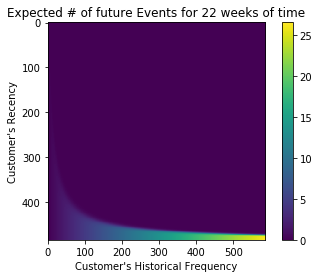

In [15]:
n_weeks=22
fig, ax = plt.subplots(1, 1)
ax = plot_frequency_recency_matrix(bgf, T=n_weeks, max_frequency=None, max_recency=None,
                             title='Expected # of future Events for {0} weeks of time'.format(n_weeks))
fig.savefig('figures/expected_number_events.png')

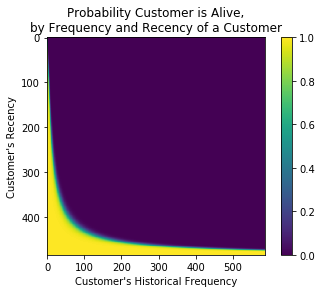

In [16]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

## Expected contributions in the upcoming cycle

In [21]:
lft_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(n_weeks,
                                                                                        lft_df['frequency'], 
                                                                                        lft_df['recency'], 
                                                                                        lft_df['T'])
lft_df.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,login,second_period_event_count,predicted_purchases
88386,548,84.0,85.0,abmorris,214,138.776213
92384,177,22.0,23.0,sayard,32,155.917036
8098,123,15.0,15.0,loocor,37,160.976586
5120,579,70.0,71.0,claudiovallejo,116,174.197770
68465,492,58.0,58.0,MichielCuijpers,167,180.944862


[[1.         0.47756658]
 [0.47756658 1.        ]]


72.04655996019379

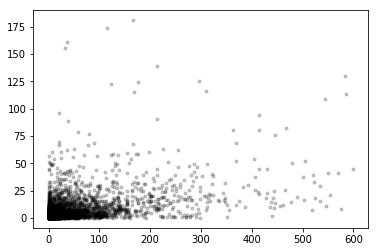

In [22]:
#user_data.dtypes
#predict_df = lft_df.merge(user_data, on='login', how='left')
#predict_df = predict_df[predict_df.second_period_event_count < 60]
plt.plot(lft_df.second_period_event_count, lft_df.predicted_purchases, 'k.', alpha=0.2)
#plt.xlim([0, 60])
#plt.ylim([0, 60])

print(np.corrcoef(lft_df.predicted_purchases, lft_df.second_period_event_count))
np.sqrt(np.mean((lft_df.predicted_purchases - lft_df.second_period_event_count) ** 2))

In [38]:
lft_df['probability_alive'] = bgf.conditional_probability_alive(1, lft_df['frequency'], 
                                                                  lft_df['recency'], n_weeks)
lft_df['alive'] = lft_df['probability_alive'] > 0.5
lft_df.head(30)

,frequency,recency,T,login,second_period_event_count,predicted_purchases,dead_or_alive,probability_alive,alive
76233,44,333.0,348.0,wilfriedvanasten,2,2.799528,0.913479,0.913479,True
89113,2,94.0,104.0,rzh4ng,0,0.525002,0.620227,0.620227,True
29091,31,105.0,107.0,miklasz,64,6.370135,0.973241,0.973241,True
18537,8,58.0,73.0,Louernos,9,2.503820,0.933436,0.933436,True
84800,2,314.0,315.0,darbour,1,0.175463,0.208718,0.208718,False
43934,4,206.0,212.0,pkernaghan,0,0.465723,0.485860,0.485860,False
54871,11,53.0,63.0,DylanGillet,0,3.906971,0.960063,0.960063,True
79402,47,217.0,222.0,puchinya,13,4.670210,0.957058,0.957058,True
47972,1,151.0,153.0,epochtalk,0,0.216188,0.336418,0.336418,False
33725,5,89.0,99.0,mcaps,0,1.205311,0.809851,0.809851,True


In [39]:
TP = np.sum((lft_df.alive == True) & (lft_df.second_period_event_count > 0))
FP = np.sum((lft_df.alive == False) & (lft_df.second_period_event_count > 0))
FN = np.sum((lft_df.alive == True) & (lft_df.second_period_event_count < 1))
TN = np.sum((lft_df.alive == False) & (lft_df.second_period_event_count < 1))

precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = (TP + TN) / (TP + FP + FN + TN)
f1score = 2 * (precision * recall) /  (precision + recall)
print('Precision: {0}'.format(np.round(precision, 3)))
print('Recall:    {0}'.format(np.round(recall, 3)))
print('Accuracy:  {0}'.format(np.round(accuracy, 3)))
print('F1-score:  {0}'.format(np.round(f1score, 4)))
#print([TP.sum(), FP.sum()])

Precision: 0.861
Recall:    0.817
Accuracy:  0.737
F1-score:  0.8382


In [37]:
pd.DataFrame([lft_df.alive == True, lft_df.second_period_event_count > 0,
             (lft_df.alive == True) & (lft_df.second_period_event_count > 0)]).transpose()

,alive,second_period_event_count,Unnamed 0
76233,True,True,True
89113,True,False,False
29091,True,True,True
18537,True,True,True
84800,False,True,False
43934,False,False,False
54871,True,False,False
79402,True,True,True
47972,False,False,False
33725,True,False,False


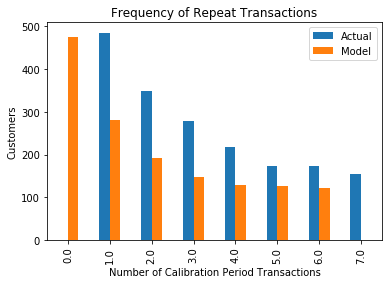

In [24]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

No handles with labels found to put in legend.


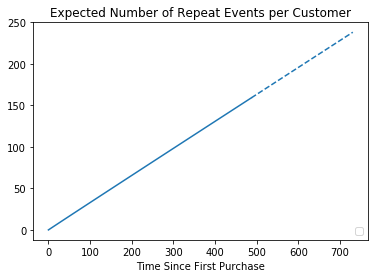

In [54]:
from lifetimes.plotting import plot_expected_repeat_purchases
plot_expected_repeat_purchases(bgf, title='Expected Number of Repeat Events per Customer')
                                   #xlabel='Time Since First Purchase',
                                   #ax=None,
                                   #label=None,
                                   #**kwargs